In [1]:
"""
scratch script to 
    take an image
    find tags
    report predicted location
"""

import marthabot.utils.realsense_utils as rsu
import dt_apriltags as atag
import numpy as np
from marthabot.map.mapper import Mapper
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



In [2]:

def draw_pose(
    overlay,
    camera_params,
    tag_size,
    pose_r,
    pose_t,
    linescale=2,
    linewidth=5,
    z_sign=1,
    label=None,
):
    opoints = (np.array(
            [
                0,0,0,
                1,0,0,
                0,1,0,
                0,0,-1 * z_sign,
                0,-1 / linescale,0,
            ]
        ).reshape(-1, 1, 3)
        
        * 0.5
        * tag_size
        * linescale
    )


    fx, fy, cx, cy = camera_params

    K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

    # rvec, _ = cv2.Rodrigues(pose_r)
    # tvec = pose_t

    dcoeffs = np.zeros(5)

    ipoints, _ = cv2.projectPoints(opoints, pose_r, pose_t, K, dcoeffs)

    ipoints = np.round(ipoints).astype(int)
    ipoints = [tuple(pt) for pt in ipoints.reshape(-1, 2)]

    textsize = max(abs(ipoints[0][0] - ipoints[1][0]),abs(ipoints[0][0] - ipoints[2][0])) / 100

    dist = round(pose_t[2][0])

    cv2.arrowedLine(overlay, ipoints[0], ipoints[1], (0, 0, 255), linewidth)
    cv2.arrowedLine(overlay, ipoints[0], ipoints[2], (0, 255, 0), linewidth)
    cv2.arrowedLine(overlay, ipoints[0], ipoints[3], (255,0,0), linewidth)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(
        overlay,
        " X",
        ipoints[1],
        font,
        textsize,
        (0, 0, 255),
        round(linewidth / 2),
        cv2.LINE_AA,
    )
    cv2.putText(
        overlay,
        " Y",
        ipoints[2],
        font,
        textsize,
        (0, 255, 0),
        round(linewidth / 2),
        cv2.LINE_AA,
    )
    cv2.putText(
        overlay,
        " Z",
        ipoints[3],
        font,
        textsize,
        (255, 0, 0),
        round(linewidth / 2),
        cv2.LINE_AA,
    )
    cv2.putText(
        overlay,
        str(dist),
        ipoints[0],
        font,
        textsize ,
        (255, 0, 0),
        round(linewidth / 2),
        cv2.LINE_AA,
    )
    if label:
        textwidth = (
            cv2.getTextSize(label, font, textsize * 3, round(linewidth / 2))[0][0] / 2
        )
        ori = (round(ipoints[4][0] - textwidth), ipoints[4][1])
        cv2.putText(
            overlay,
            label,
            ori,
            font,
            textsize * 3,
            (50, 255, 50),
            round(linewidth / 2),
            cv2.LINE_AA,
        )

def rt2orientation(rt):
    r13 = rt[0,2]

    r23 = rt[1,2]
    r33 = rt[2,2]

    r11 = rt[0,0]
    r12 = rt[0,1]

    ry = np.rad2deg(np.arcsin(-r13))
    rz = np.rad2deg(np.arctan2(r12,r11))
    rx = np.rad2deg(np.arctan2(r23,r33))
    return (rz,ry,rx)


def combine_rt(r, t):
    """Combine rotation and transformation matrices into one matrix

    :param r: 3x3 rotation matrix
    :type r: np.ndarray
    :param t: 3x1 translation matrix
    :type t: np.ndarray
    :return: 4x4 transformation matrix
    :rtype: np.ndarray
    """
    return np.array(
        [
            [r[0, 0], r[0, 1], r[0, 2], t[0, 0]],
            [r[1, 0], r[1, 1], r[1, 2], t[1, 0]],
            [r[2, 0], r[2, 1], r[2, 2], t[2, 0]],
            [0, 0, 0, 1],
        ]
    )



In [3]:

# create detector
detector = atag.Detector(families="tagStandard41h12")

#get pipe
pipe = rsu.get_pipe()

#camera intrinsics
fx, fy, cx, cy = (
    952., 952.,
    # 952., 556.,
    1920.0/2, 1080.0/2.,
    # 1335.5, 1335.5,
    # 1280.0/2, 720.0/2,
    # 942.0,934.0,623.0,331.0
    # 952.0,942.0,632.0,331.0 #output.jpg
    # 632.0,331.0,


)
camera_params = [fx, fy, cx, cy]

ft2m = 0.3048

size = 8
# size = 0.5

# convert outer edge size to tag size
size = size / 9 * 5

size = size * 12 * ft2m

# size = 0.112888

def deg2vec(angle):
    return [np.cos(np.deg2rad(angle)),np.sin(np.deg2rad(angle))]
def vec2deg(vec):
    return np.rad2deg(np.arctan2(vec[0],vec[1]))


np.set_printoptions(precision=3, suppress=True, formatter={'float': '{: 0.3f}'.format})

it = 1

m = Mapper("/home/pi/HSI/marthabot/map/RhodeMap.yaml",
    "/home/pi/HSI/marthabot/map/MapConfiguration.yaml")

fig=plt.figure(figsize=(10,5), dpi= 600, facecolor='w', edgecolor='k')
plt.figure(fig)


<Figure size 6000x3000 with 0 Axes>

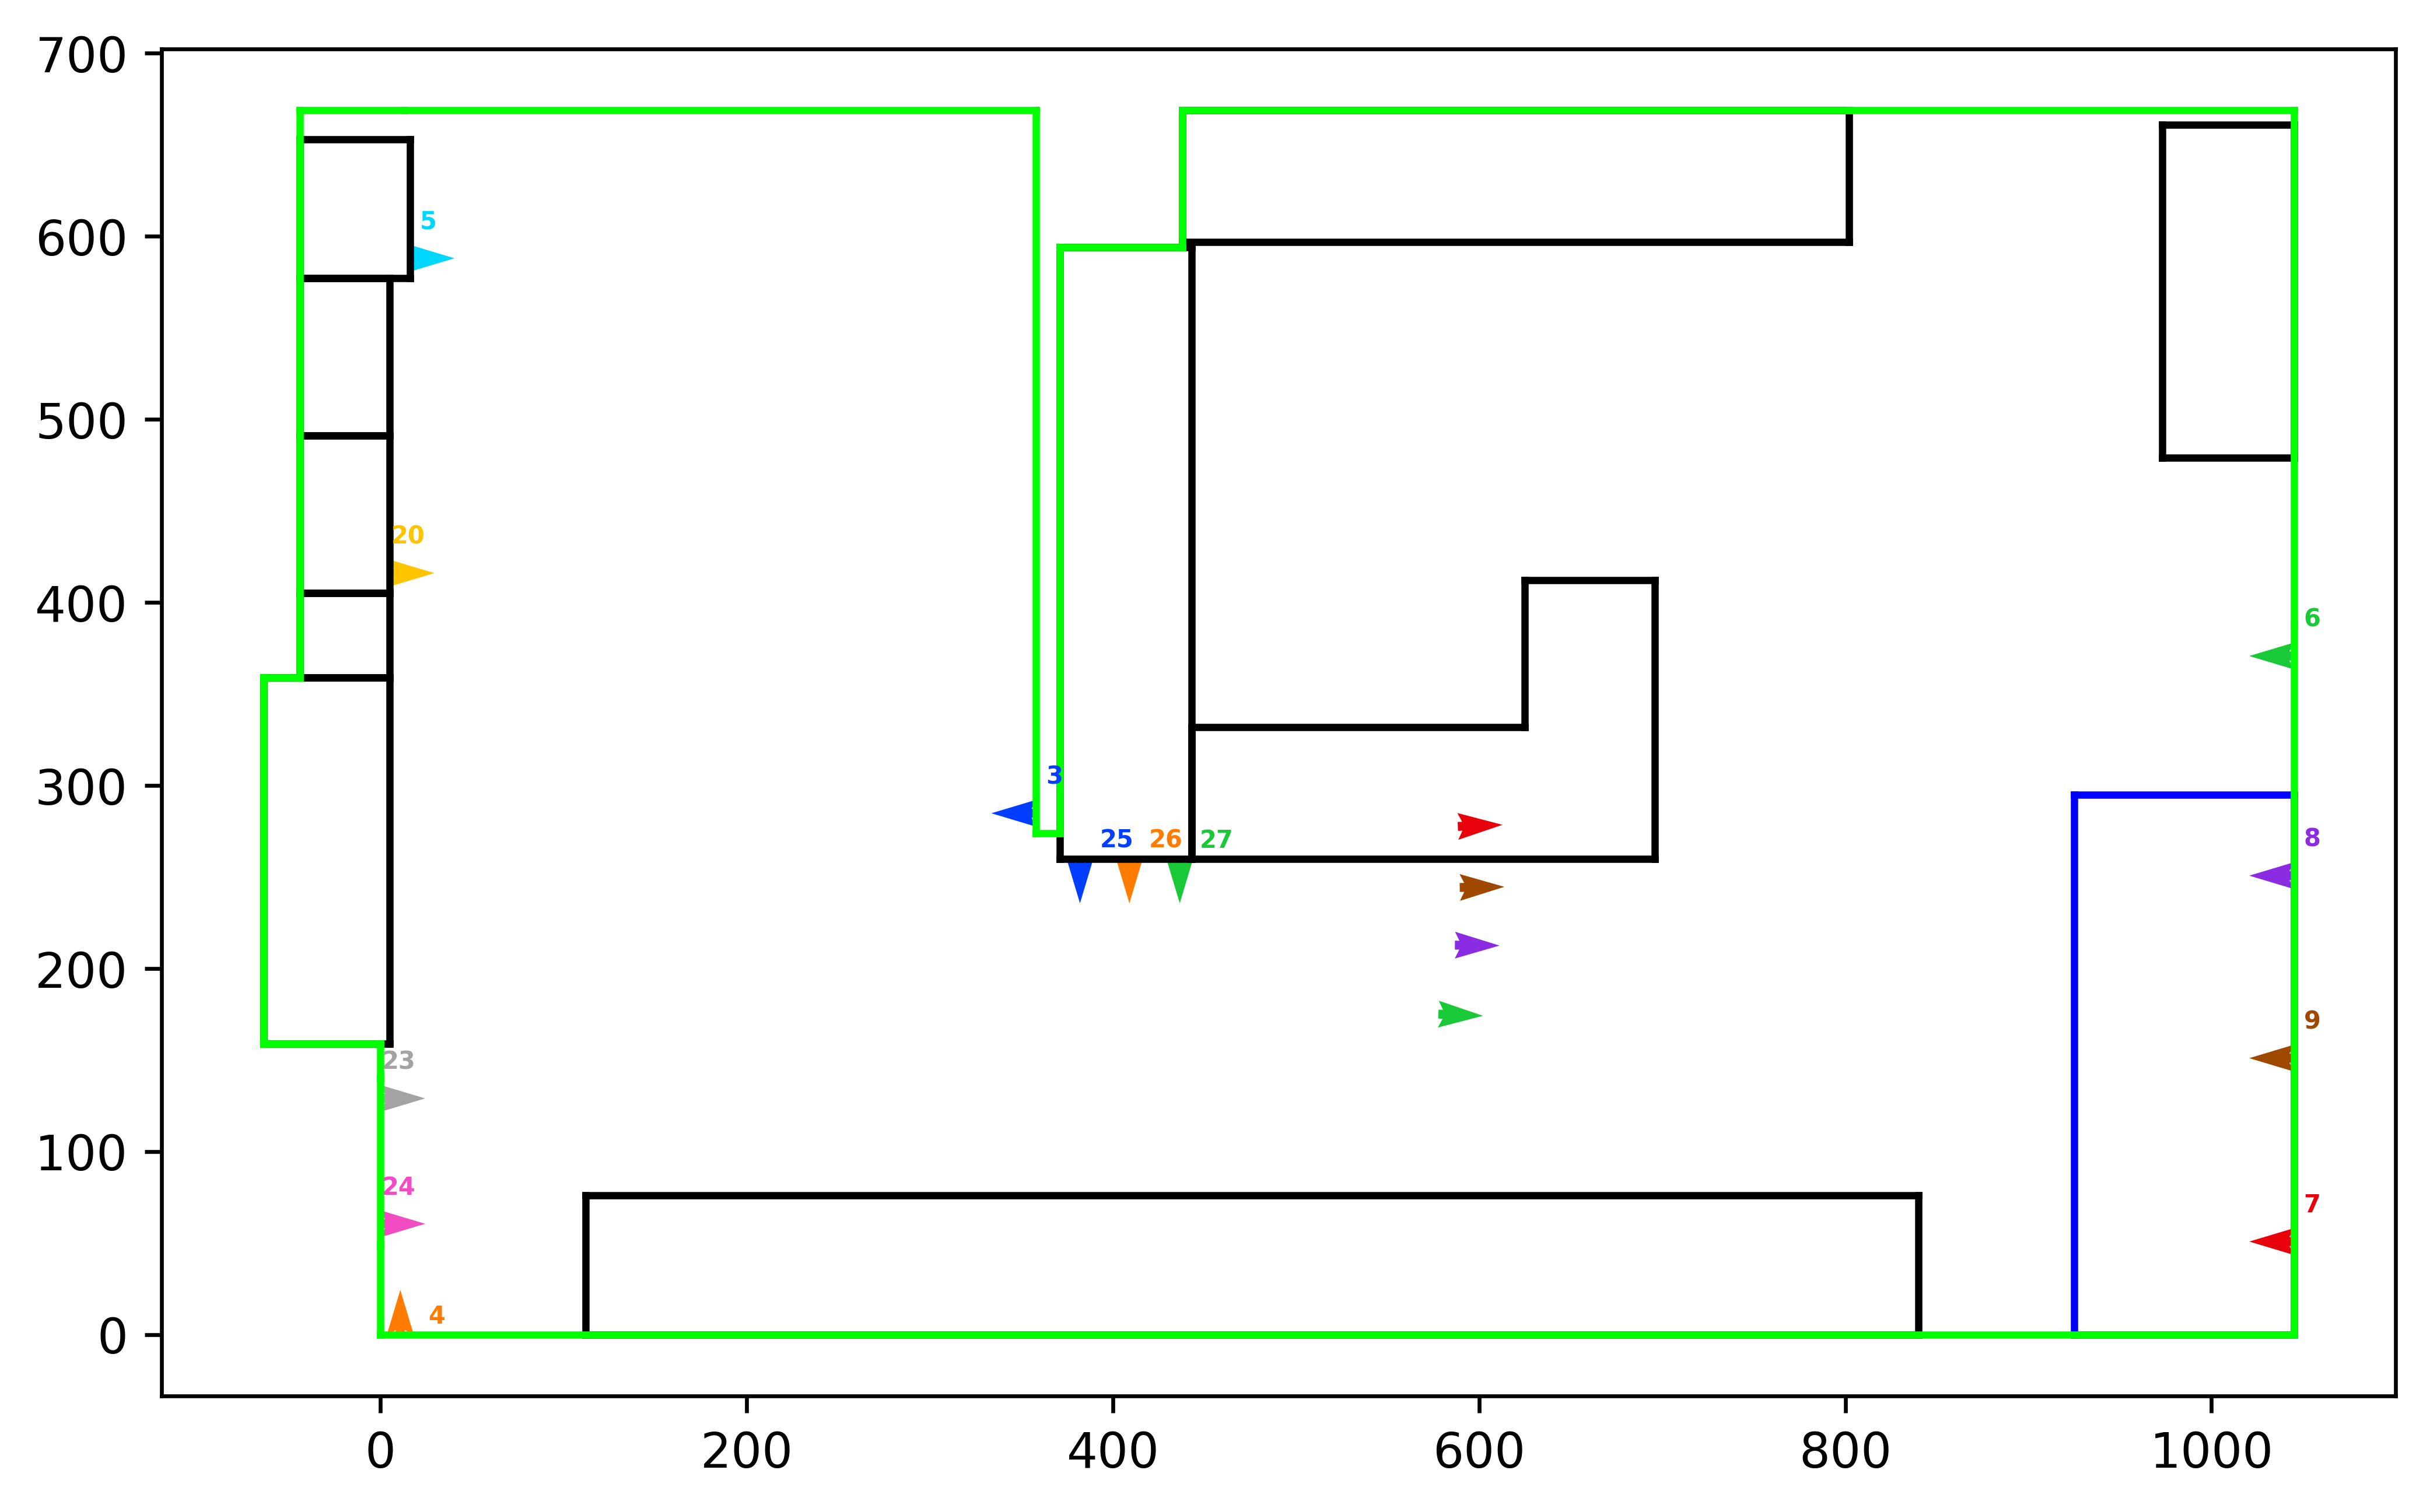

In [6]:

fig=plt.figure(figsize=(10,5), dpi= 600, facecolor='w', edgecolor='k')
plt.figure(fig)

plt.show()

def localize():
    obs = {}

    for i in range(it):
        if it > 1:
            print("image",i)

        image, _ = rsu.get_frame(pipe)

        results = detector.detect(image,True,camera_params,size)

        # debug = True
        debug = False

        for tag in results:
            if not tag.tag_id in m.tags[:,0]:
                print("===============================")
                print(f"Skipping tag {tag.tag_id} as it is not in the map file")
                continue
            if debug: print("===============================")
            if debug: print("Tag ", tag.tag_id)
            rt = combine_rt(tag.pose_R,tag.pose_t)
            rt = np.linalg.inv(rt)
            # if debug: print("RT: \n", rt)
            # TODO get rid of intermediate heading calcs
            rz,ry,rx = rt2orientation(rt)
            if debug: print("Translation:",round(rt[0,3]),round(rt[1,3]),round(rt[2,3]))
            if debug: print("Orientation:",round(rz),round(ry),round(rx))
            pose = np.array([0.,0.,0.,1.]).reshape((4,1)).astype(float)
            vec = np.array([50,0,0,1]).reshape((4,1)).astype(float)
            if debug: print("Robot Frame: ", pose.T)
            pose = m.robot2cam(pose)
            vec = m.robot2cam(vec)
            if debug: print("Cam Frame: ", pose.T)
            pose = rt @ pose 
            vec = rt @ vec 
            if debug: print("Tag Frame: ", pose.T)
            pose = m.tag2world(pose,tag.tag_id)
            vec = m.tag2world(vec,tag.tag_id)
            heading = np.arctan2(vec[1,0]-pose[1,0],vec[0,0]-pose[0,0])
            heading = np.arctan2(vec[1,0]-pose[1,0],vec[0,0]-pose[0,0])
            if debug: print("World Frame: ", pose.T)
            if debug: print("Tag ", tag.tag_id, pose.T, round(rz), round(ry), round(rx))
            pose = [p[0] for p in pose]
            pose.append(heading)
            if tag.tag_id in obs:
                obs[tag.tag_id].append([pose[0],pose[1],pose[2],pose[3],heading])
            else:
                obs[tag.tag_id] = [[pose[0],pose[1],pose[2],pose[3],heading]]
        if len(results) == 0:
            print("No tags detected")

        poses = []
        palette = sns.color_palette(None, len(obs))
        p_i = 0
        c_dict = {}
        for id, ob in obs.items():
            if id not in c_dict.keys():
                c_dict[id] = palette[p_i]
                p_i += 1
            poses.extend([[str(id), ob[p][0],ob[p][1],ob[p][4],id] for p in range(len(ob))])
     
        poses = np.array(poses)
    plt.figure(fig)
    plt.gcf().clf()
    clear_output(wait=True)

    m.plot_map("marthabot/map/map",np.array(poses),plt.gcf())
    plt.show()



In [ ]:
def set_cam(nfx,nfy,ncx,ncy,nit):
    global fx, fy,cx,cy, it
    fx, fy,cx,cy, it = nfx,nfy,ncx,ncy, nit
    camera_params = [fx, fy, cx, cy]
    

interact(set_cam,nfx = fx, nfy = fy, ncx = cx, ncy = cy,nit = (1,100))

interactive(children=(FloatSlider(value=952.0000000000002, description='nfx', max=2856.000000000001, min=-952.…

<function __main__.set_cam(nfx, nfy, ncx, ncy, nit)>

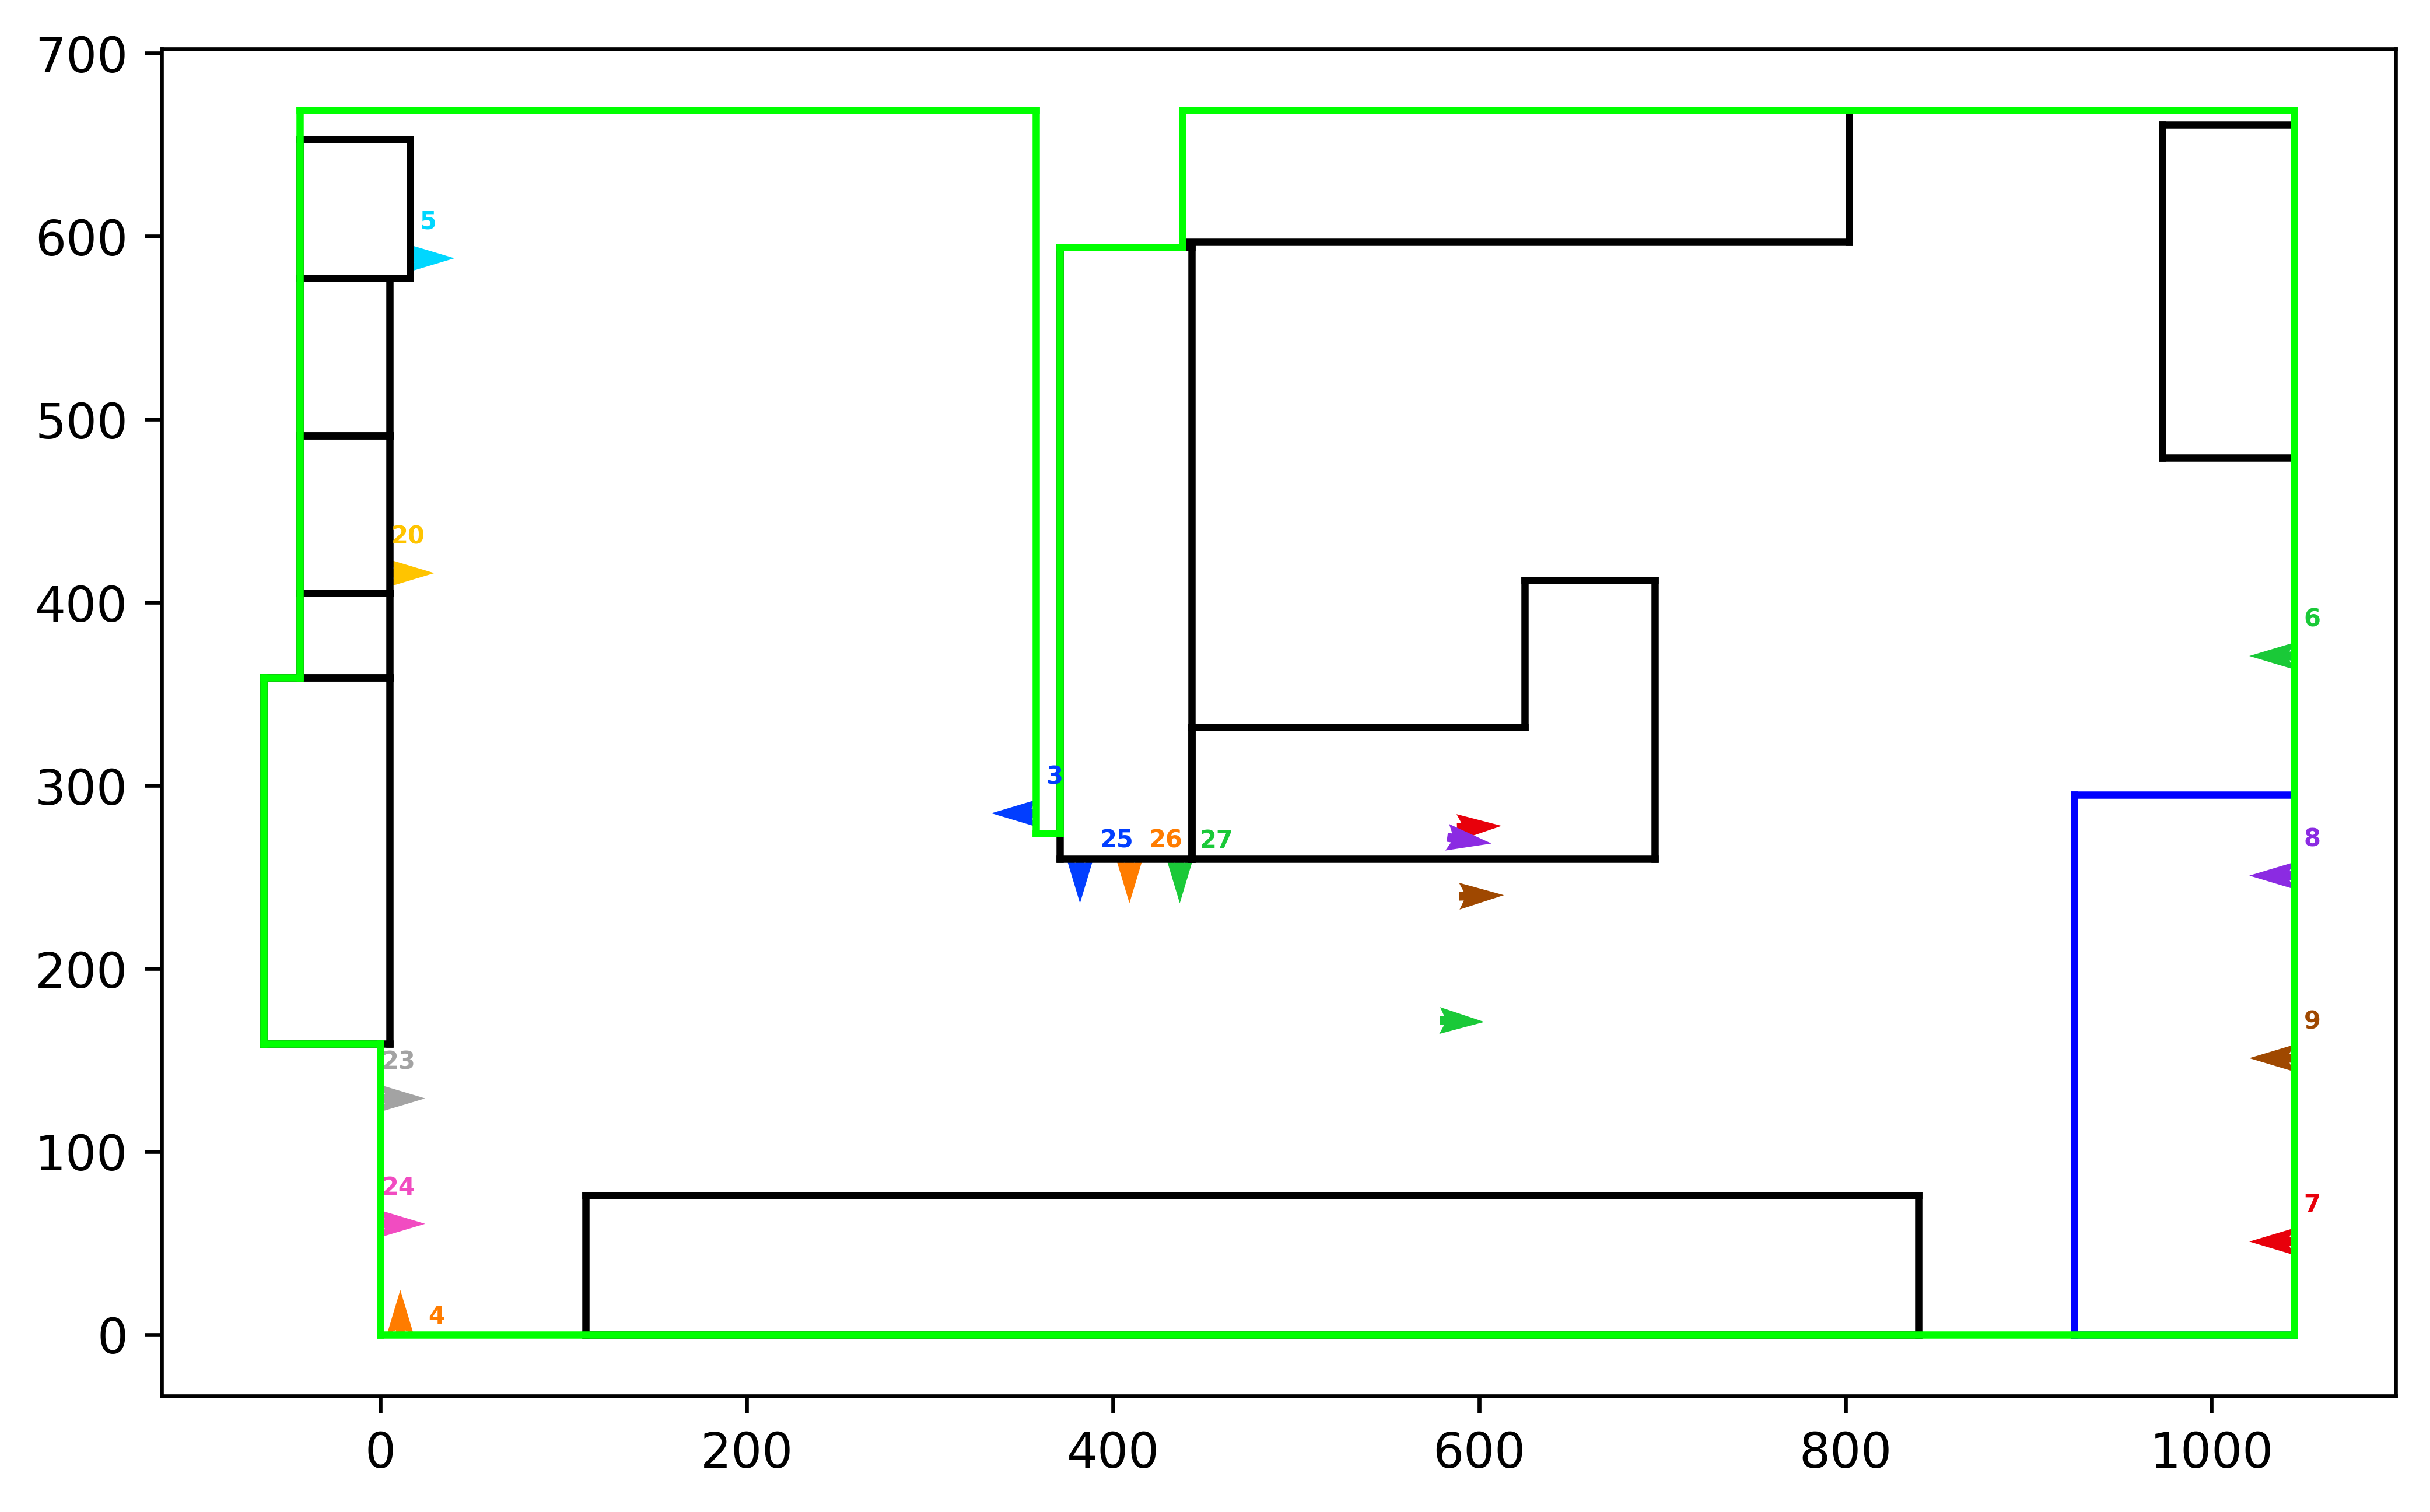

In [7]:
localize()

In [ ]:
import pyrealsense2 as rs
cfg: rs.config = rs.config()
print(rs.intrinsics())
ctx = rs.context()
if len(ctx.devices) > 0:

    for d in ctx.devices:

        print ('Found device: ', \
            d.get_info(rs.camera_info.name),
            d.get_info(rs.camera_info.serial_number), 
            "| USB: ", d.get_info(rs.camera_info.usb_type_descriptor), 
        )
        print("with extrinsincs",
            rs.extrinsics()
        )
        

else:

    print("No Intel Device connected")

In [ ]:
import pyrealsense2 as rs
import time
import json

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07", "0B3A", "0B5C"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No D400 product line device that supports advanced mode was found")

try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Get each control's current value
    print("Depth Control: \n", advnc_mode.get_depth_control())
    print("RSM: \n", advnc_mode.get_rsm())
    print("RAU Support Vector Control: \n", advnc_mode.get_rau_support_vector_control())
    print("Color Control: \n", advnc_mode.get_color_control())
    print("RAU Thresholds Control: \n", advnc_mode.get_rau_thresholds_control())
    print("SLO Color Thresholds Control: \n", advnc_mode.get_slo_color_thresholds_control())
    print("SLO Penalty Control: \n", advnc_mode.get_slo_penalty_control())
    print("HDAD: \n", advnc_mode.get_hdad())
    print("Color Correction: \n", advnc_mode.get_color_correction())
    print("Depth Table: \n", advnc_mode.get_depth_table())
    print("Auto Exposure Control: \n", advnc_mode.get_ae_control())
    print("Census: \n", advnc_mode.get_census())

    #To get the minimum and maximum value of each control use the mode value:
    query_min_values_mode = 1
    query_max_values_mode = 2
    current_std_depth_control_group = advnc_mode.get_depth_control()
    min_std_depth_control_group = advnc_mode.get_depth_control(query_min_values_mode)
    max_std_depth_control_group = advnc_mode.get_depth_control(query_max_values_mode)
    print("Depth Control Min Values: \n ", min_std_depth_control_group)
    print("Depth Control Max Values: \n ", max_std_depth_control_group)

    # Set some control with a new (median) value
    current_std_depth_control_group.scoreThreshA = int((max_std_depth_control_group.scoreThreshA - min_std_depth_control_group.scoreThreshA) / 2)
    advnc_mode.set_depth_control(current_std_depth_control_group)
    print("After Setting new value, Depth Control: \n", advnc_mode.get_depth_control())

    # Serialize all controls to a Json string
    serialized_string = advnc_mode.serialize_json()
    print("Controls as JSON: \n", serialized_string)
    as_json_object = json.loads(serialized_string)

    # We can also load controls from a json string
    # For Python 2, the values in 'as_json_object' dict need to be converted from unicode object to utf-8
    if type(next(iter(as_json_object))) != str:
        as_json_object = {k.encode('utf-8'): v.encode("utf-8") for k, v in as_json_object.items()}
    # The C++ JSON parser requires double-quotes for the json object so we need
    # to replace the single quote of the pythonic json to double-quotes
    json_string = str(as_json_object).replace("'", '\"')
    advnc_mode.load_json(json_string)

except Exception as e:
    print(e)
    pass